## Import Library

In [455]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from openpyxl import Workbook

## Read Data

In [456]:
# laod data
url = "Data/MANU.csv"
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-31,21.240000,21.600000,20.709999,20.940001,20.024546,25500
1,2018-11-01,21.100000,21.500000,20.809999,21.330000,20.397497,24700
2,2018-11-02,21.330000,21.490000,21.110001,21.260000,20.330559,19500
3,2018-11-05,21.370001,21.389999,21.010000,21.250000,20.320997,20300
4,2018-11-06,21.180000,21.740000,21.170000,21.740000,20.789572,25700


## EDA

In [457]:
df.shape

(1257, 7)

In [458]:
# cek info datasete
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1257 non-null   object 
 1   Open       1257 non-null   float64
 2   High       1257 non-null   float64
 3   Low        1257 non-null   float64
 4   Close      1257 non-null   float64
 5   Adj Close  1257 non-null   float64
 6   Volume     1257 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


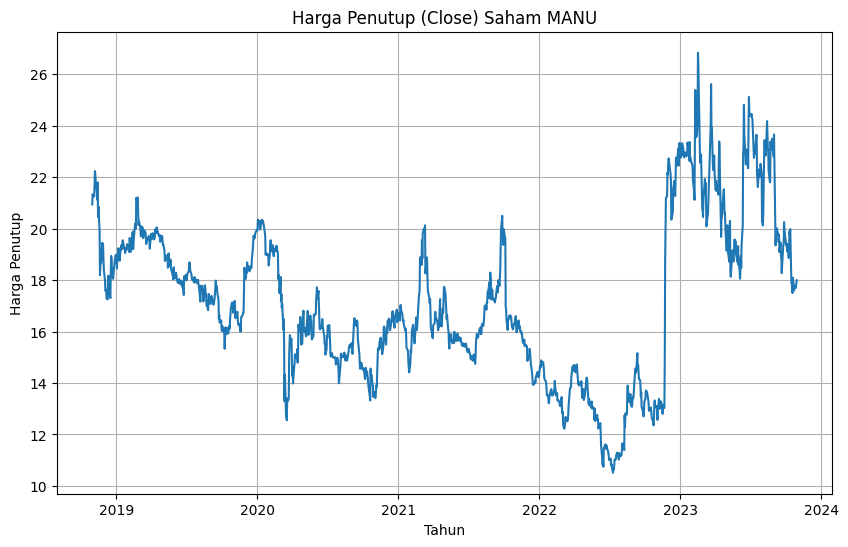

In [459]:
# Mengonversi kolom 'Date' menjadi tipe data datetime
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Date', y='Close')
plt.title('Harga Penutup (Close) Saham MANU')
plt.xlabel('Tahun')
plt.ylabel('Harga Penutup')
plt.grid(True)
plt.show()

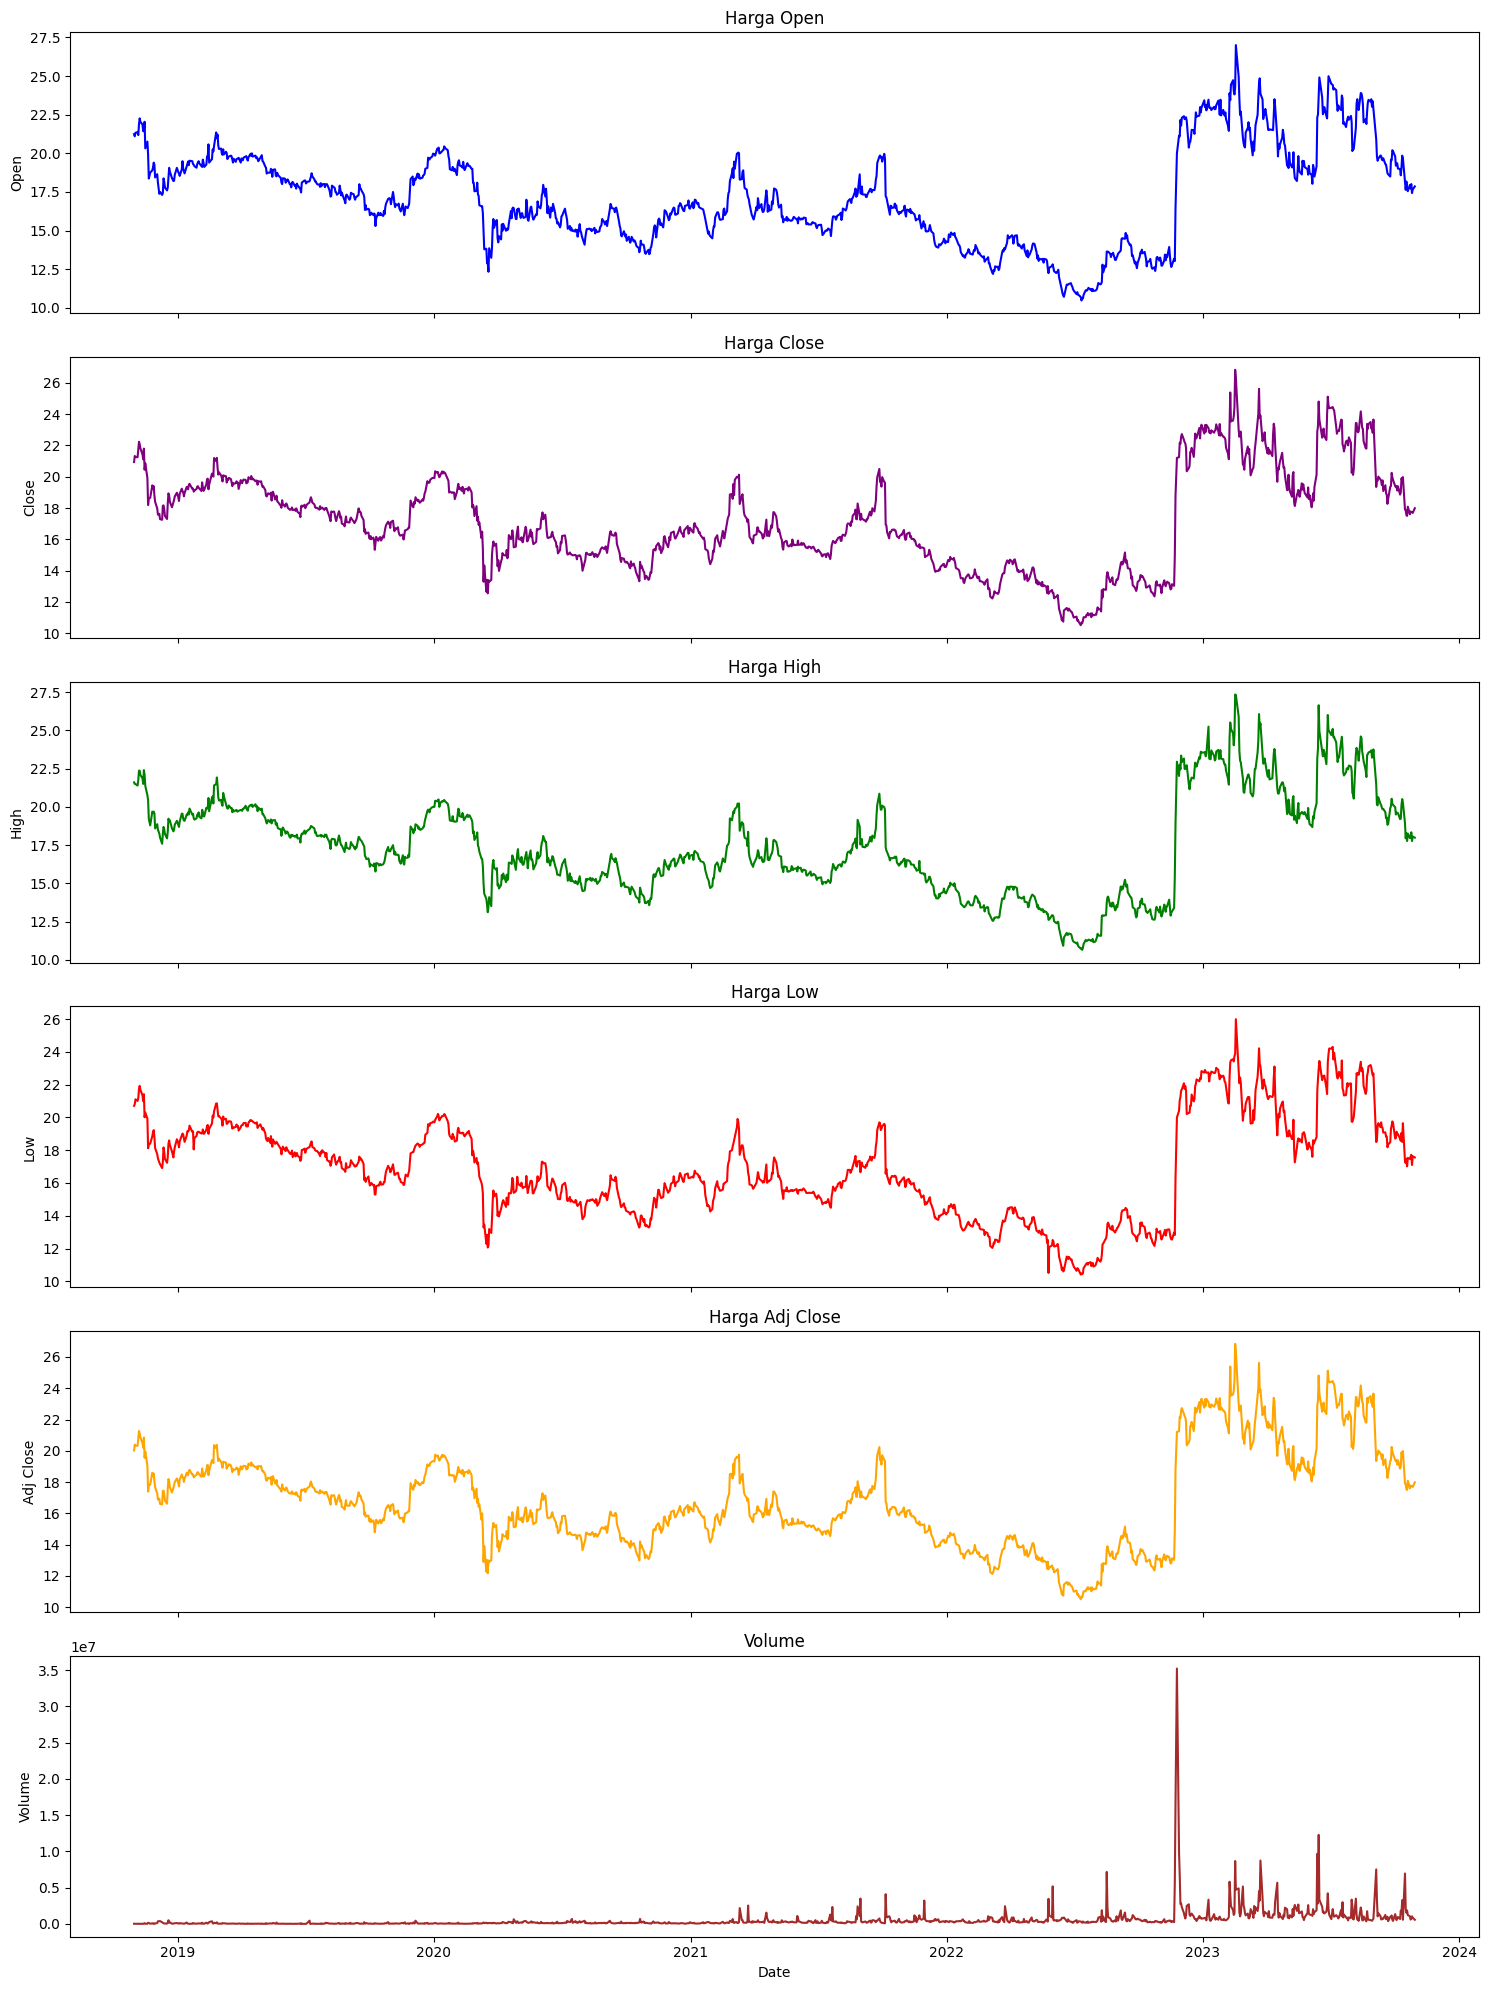

In [460]:
# Membuat subplots
fig, axes = plt.subplots(6, 1, figsize=(15, 20), sharex=True)

# Grafik untuk Open
sns.lineplot(ax=axes[0], data=df, x='Date', y='Open', color='blue')
axes[0].set_title('Harga Open')

# Grafik untuk Close
sns.lineplot(ax=axes[1], data=df, x='Date', y='Close', color='purple')
axes[1].set_title('Harga Close')

# Grafik untuk High
sns.lineplot(ax=axes[2], data=df, x='Date', y='High', color='green')
axes[2].set_title('Harga High')

# Grafik untuk Low
sns.lineplot(ax=axes[3], data=df, x='Date', y='Low', color='red')
axes[3].set_title('Harga Low')

# Grafik untuk Adj Close
sns.lineplot(ax=axes[4], data=df, x='Date', y='Adj Close', color='orange')
axes[4].set_title('Harga Adj Close')

# Grafik untuk Volume
sns.lineplot(ax=axes[5], data=df, x='Date', y='Volume', color='brown')
axes[5].set_title('Volume')

# Menampilkan plot
plt.tight_layout()
plt.show()

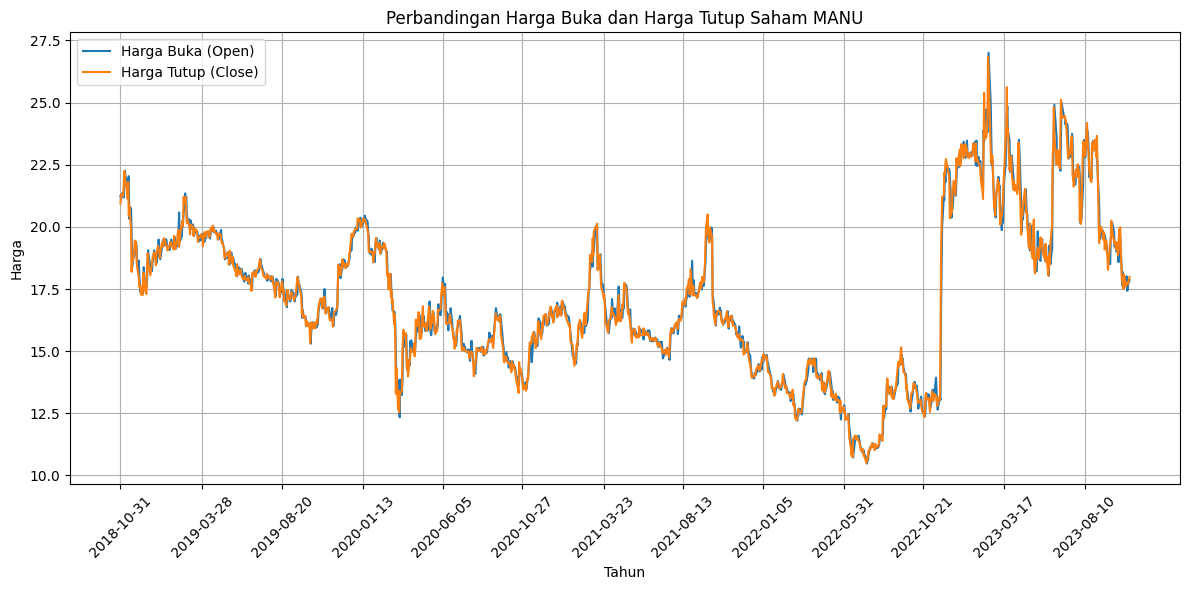

In [461]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Open'], label='Harga Buka (Open)')
plt.plot(df['Date'], df['Close'], label='Harga Tutup (Close)')
plt.title('Perbandingan Harga Buka dan Harga Tutup Saham MANU')
plt.xlabel('Tahun')
plt.ylabel('Harga')
plt.xticks(df['Date'][::100], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

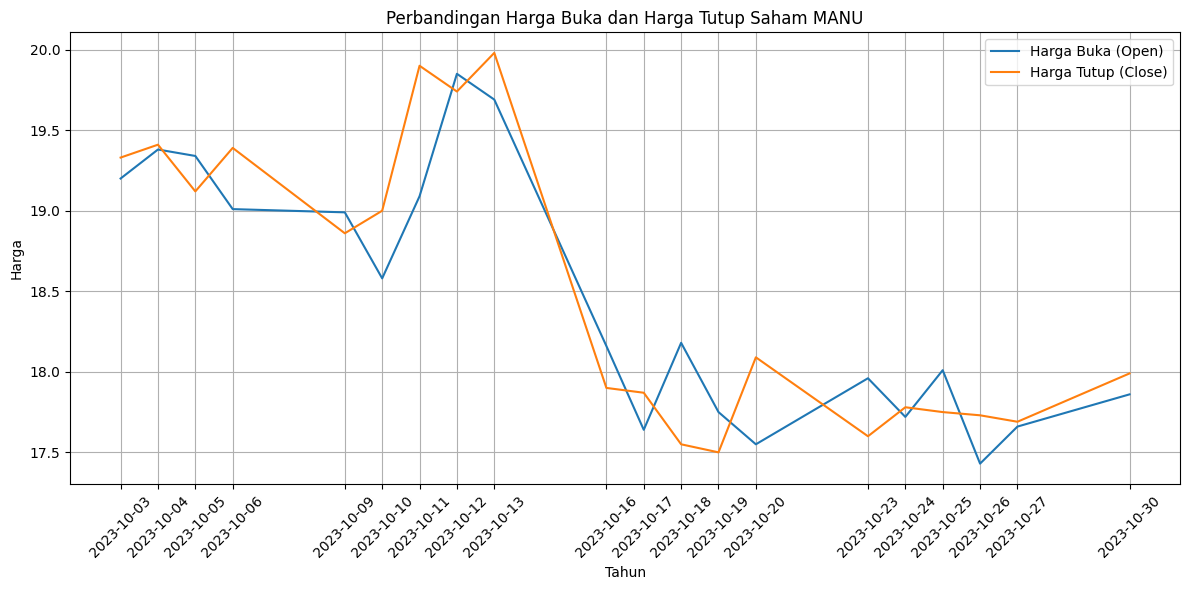

In [462]:
# Zoom perbandingan antara harga buka dan tutup
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-20:], df['Open'][-20:], label='Harga Buka (Open)')
plt.plot(df['Date'][-20:], df['Close'][-20:], label='Harga Tutup (Close)')
plt.title('Perbandingan Harga Buka dan Harga Tutup Saham MANU')
plt.xlabel('Tahun')
plt.ylabel('Harga')
plt.xticks(df['Date'][-20:], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [463]:
df.corr()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.000000,0.035482,0.057158,0.019190,0.042266,0.126234,0.361583
Open,0.035482,1.000000,0.994819,0.995662,0.991956,0.987714,0.224785
High,0.057158,0.994819,1.000000,0.992610,0.996076,0.993782,0.275086
Low,0.019190,0.995662,0.992610,1.000000,0.995633,0.989950,0.205592
Close,0.042266,0.991956,0.996076,0.995633,1.000000,0.996357,0.246727
Adj Close,0.126234,0.987714,0.993782,0.989950,0.996357,1.000000,0.276740
Volume,0.361583,0.224785,0.275086,0.205592,0.246727,0.276740,1.000000


## Preprocessing

In [464]:
# cek missing value
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [465]:
# Cek duplikasi
df.duplicated().sum()

0

In [466]:
# Mengecek apakah selain kolom volumen terdapat yang kosong. Jika ada, hapus.
if df[['Open', 'High', 'Low', 'Close', 'Adj Close']].isnull().values.any():
    # Cetak nilai-nilai yang kosong
    print("Nilai yang kosong ada pada kolom :")
    print(df[df[['Open', 'High', 'Low', 'Close', 'Adj Close']].isnull().any(axis=1)])

    # hapus jika ada yang kosong
    df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Adj Close'], inplace=True)
    print("Nilai kosong telah dihapus !")
else :
    print("Nilai yang kosong tidak ditemukan !")


Nilai yang kosong tidak ditemukan !


## Ekstraksi Feature

##### Menghitung Nilai RSI

In [467]:
# define the period parameter for RSI
period_RSI=14

In [468]:
# Menghitung selis harga tutup hari ini dengan harga tutup sebelumnya
differencePrice = df['Close'].diff()
differencePriceValues=differencePrice.values

In [469]:
positive_differences=0
negative_differences=0
current_average_positive=0
current_average_negative=0
price_index=0
RSI=[]

In [470]:
for difference in differencePriceValues[1:]:
     
    if difference>0:
        positive_difference=difference
        negative_difference=0                
    if difference<0:
        negative_difference=np.abs(difference)
        positive_difference=0
    if difference==0:
        negative_difference=0
        positive_difference=0
     
    # this if block is used to initialize the averages
    if (price_index<period_RSI):
         
        current_average_positive=current_average_positive+(1/period_RSI)*positive_difference
        current_average_negative=current_average_negative+(1/period_RSI)*negative_difference
               
        if(price_index==(period_RSI-1)):
            #safeguard against current_average_negative=0
            if current_average_negative!=0:
                RSI.append(100 - 100/(1+(current_average_positive/current_average_negative)))           
            else:
                RSI.append(100)
    # this is executed for the time steps > period_RSI, the averages are updated recursively        
    else:
         
        current_average_positive=((period_RSI-1)*current_average_positive+positive_difference)/(period_RSI)
        current_average_negative=((period_RSI-1)*current_average_negative+negative_difference)/(period_RSI)
         
        #safeguard against current_average_negative=0
        if current_average_negative!=0:
            RSI.append(100 - 100/(1+(current_average_positive/current_average_negative)))   
        else:
            RSI.append(100)
             
    price_index=price_index+1

In [471]:
#create the RSI time series
RSI_series=pd.Series(data=RSI,index=df['Close'].index[period_RSI:])

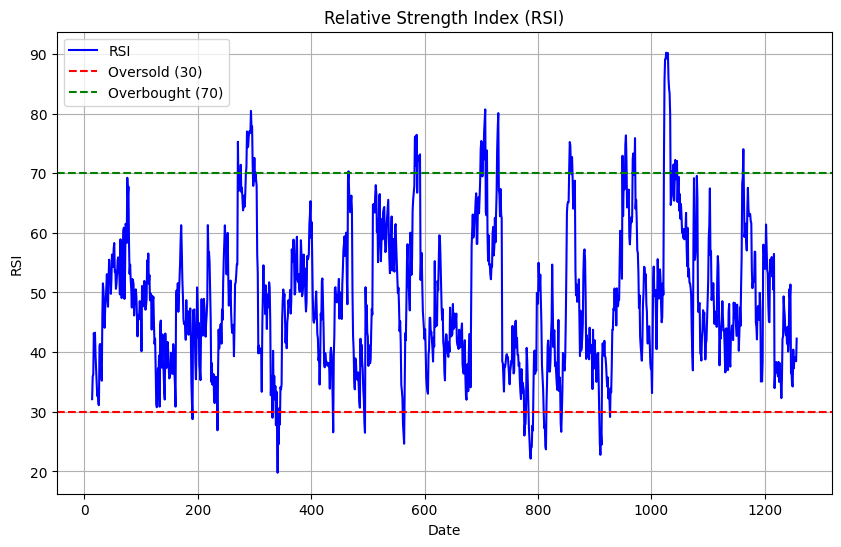

In [472]:
# Plot RSI
plt.figure(figsize=(10, 6))
plt.plot(RSI_series, label='RSI', color='blue')
plt.axhline(y=30, color='r', linestyle='--', label='Oversold (30)')
plt.axhline(y=70, color='g', linestyle='--', label='Overbought (70)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

In [473]:
df['RSI'] = RSI_series
# df[['RSI']]

In [474]:
df = df.dropna()

##### Menentukan target atau label

In [475]:
# untuk menentukan label pada kelas maka melakukan perbandingan dari hasil RSI dengen ketentuan:
# 1. Jika > 70 maka Overbought (Naik === Jual) maka dilabelkan menajdi 1
# 2. Jika < 30 maka Oversold (Tutun === Beli) maka dilabelkan menajdi -1
# 3. Jika 30 - 70 maka hold (Tahan) maka dilabelkan menajdi 0

In [476]:
df['Target'] = np.where(df['RSI'] > 70, 1, np.where(df['RSI'] < 30, -1, 0))

In [477]:
df['Target'].value_counts()

Target
 0    1135
 1      70
-1      38
Name: count, dtype: int64

In [478]:
df[['Close', 'RSI', 'Target']]

,Close,RSI,Target
14,18.190001,32.119622,0
15,18.610001,35.890401,0
16,18.650000,36.253585,0
17,19.450001,43.186013,0
18,19.250000,41.957539,0
...,...,...,...
1252,17.780001,39.151459,0
1253,17.750000,38.943224,0
1254,17.730000,38.795087,0
1255,17.690001,38.479828,0


#### Normalisasi data

In [479]:
# Menginisialisasi Min-Max Scaler
scaler = MinMaxScaler()

# Memilih kolom numerik yang akan dinormalisasi
columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI']

# Memilih kolom yang tidak akan dinormalisasi
columns_to_leave = ['Target']

# Salin DataFrame asli jika diperlukan
df_normalized = df.copy()

# Lakukan normalisasi pada kolom-kolom yang dipilih
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])

In [480]:
df_normalized.count()

Date         1243
Open         1243
High         1243
Low          1243
Close        1243
Adj Close    1243
Volume       1243
RSI          1243
Target       1243
dtype: int64

In [481]:
# Tampilkan hasil
df_normalized

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,Target
14,2018-11-20,0.571429,0.585731,0.494548,0.470300,0.421603,0.004616,0.175147,0
15,2018-11-21,0.477603,0.513189,0.510584,0.496020,0.446198,0.003747,0.228707,0
16,2018-11-23,0.500605,0.487410,0.512508,0.498469,0.448540,0.000977,0.233866,0
17,2018-11-26,0.509685,0.541367,0.542014,0.547459,0.495388,0.002555,0.332333,0
18,2018-11-27,0.521186,0.535971,0.556767,0.535211,0.483676,0.001011,0.314884,0
...,...,...,...,...,...,...,...,...,...
1252,2023-10-24,0.438257,0.441847,0.461835,0.445193,0.445193,0.017203,0.275026,0
1253,2023-10-25,0.455811,0.460432,0.468890,0.443356,0.443356,0.020695,0.272069,0
1254,2023-10-26,0.420702,0.426259,0.429121,0.442131,0.442131,0.029705,0.269965,0
1255,2023-10-27,0.434625,0.443645,0.463117,0.439682,0.439682,0.024351,0.265487,0


#### Balance Data menggunakan SMOTE

In [482]:
# Belence data
X = df_normalized[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI']]
y = df_normalized['Target']

Target
 0    1135
 1      70
-1      38
Name: count, dtype: int64

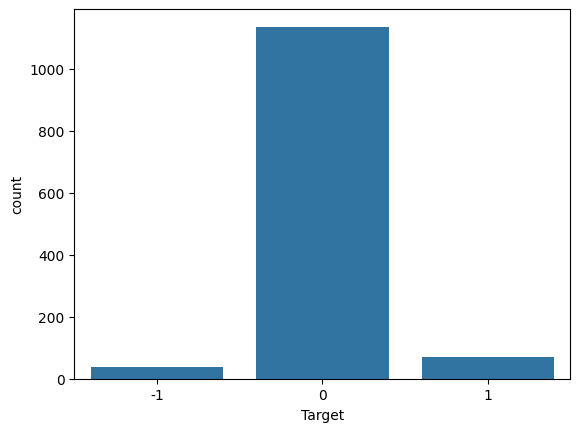

In [483]:
# Menghitung jumlah nilai pada kolom 'Target' sebelum dilakukan balance data
sns.countplot(x='Target', data=pd.DataFrame({'Target': y}))
y.value_counts()

In [484]:
# SOMTE
# Menginisialisasi Min-Max Scaler
smote = SMOTE(random_state=42)

# Terapkan SMOTE untuk menyeimbangkan kelas pada dataset
X_smote, y_smote = smote.fit_resample(X, y)

Target
 0    1135
-1    1135
 1    1135
Name: count, dtype: int64

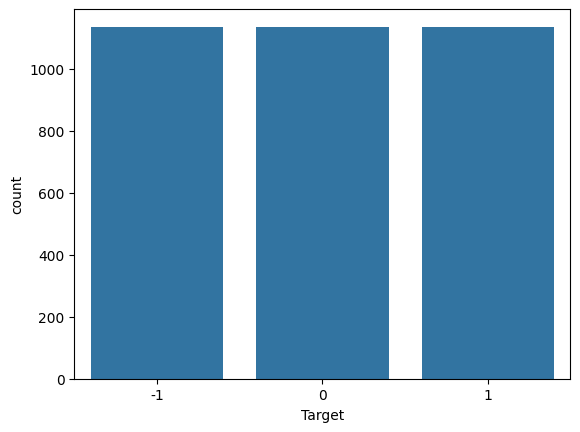

In [485]:
# Menghitung jumlah nilai pada kolom 'Target' setelh dilakukan balance data
sns.countplot(x='Target', data=pd.DataFrame({'Target': y_smote}))
y_smote.value_counts()

In [486]:
# Gabungkan X dan y menjadi satu dataframe
df_smote = pd.concat([X_smote, y_smote], axis=1)

## Pembagian Data

In [487]:
# # Jumlah data yang imbalance
# df_normalized.count()

In [488]:
# # Jumlah data balance menggunakan SMOTE
# df_smote.count()

In [489]:
feature_columns = ['Open', 'Low', 'High', 'Close', 'Adj Close', 'Volume', 'RSI']
target_column = 'Target'

In [490]:
# X_imb = df_normalized[['Open', 'Low', 'High', 'Close', 'Adj Close', 'Volume', 'RSI']]
# y_imb = df_normalized['Target']
X_imb = df_normalized[feature_columns]
y_imb = df_normalized[target_column]

In [491]:
X_bal = df_smote[feature_columns]
y_bal = df_smote[target_column]

In [492]:
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imb, y_imb, test_size=0.2, random_state=0)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

## Modeling

#### Hyperparameter tuning menggunakan GridSearch

In [493]:
svm = SVC(random_state=0)

In [494]:
parameters = {
    'kernel' : ['rbf', 'poly'],
    'C' : [1, 10, 100, 1000],
    'gamma' : [1, 0.1, 0.01, 0.001, 0.0001]
    # nilai default degree adalah 3
}

In [495]:
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision_macro": make_scorer(precision_score, average='macro'),
    "Recall_macro": make_scorer(recall_score, average='macro'),
    "F1_macro": make_scorer(f1_score, average='macro'),
    # "F1_micro": make_scorer(f1_score, average='micro'),
}

#### Menentukan paramter terbaik pada data imbalance

##### Menggunakan 3-fold

In [496]:
gridSearch_k3_imb = GridSearchCV(estimator=svm, param_grid=parameters, cv=3, n_jobs=6, scoring=scoring, refit='Accuracy', verbose=1)
gridSearch_k3_imb.fit(X_train_imb, y_train_imb)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'Precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'Recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

In [497]:
# pd.DataFrame(grid_search_k3.cv_results_).sort_values('rank_test_score')
pd.DataFrame(gridSearch_k3_imb.cv_results_).sort_values('rank_test_Accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,...,split2_test_Recall_macro,mean_test_Recall_macro,std_test_Recall_macro,rank_test_Recall_macro,split0_test_F1_macro,split1_test_F1_macro,split2_test_F1_macro,mean_test_F1_macro,std_test_F1_macro,rank_test_F1_macro
30,0.016936,0.000711,0.000503,0.000711,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.987952,0.996979,...,0.982456,0.971619,0.008177,2,0.951496,0.983574,0.990438,0.975170,0.016972,1
32,0.014508,0.000000,0.000000,0.000000,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.984940,0.996979,...,0.982456,0.960291,0.031346,3,0.938380,0.990438,0.990438,0.973085,0.024541,2
20,0.001669,0.002360,0.016923,0.005372,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.984940,0.990937,...,0.982456,0.955301,0.020655,4,0.935248,0.964925,0.990438,0.963537,0.022552,3
34,0.010419,0.007367,0.005210,0.007367,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.987952,0.984894,...,0.982456,0.934241,0.039070,5,0.948978,0.935349,0.990438,0.958255,0.023427,4
22,0.008879,0.006555,0.008103,0.005928,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.981928,0.984894,...,0.982456,0.922545,0.042630,6,0.927192,0.935349,0.990438,0.950993,0.028090,5
10,0.008059,0.006031,0.008059,0.006031,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.981928,0.978852,...,0.964912,0.900747,0.046655,8,0.930343,0.906487,0.980378,0.939069,0.030790,6
31,0.010649,0.007625,0.004836,0.006839,1000,1,poly,"{'C': 1000, 'gamma': 1, 'kernel': 'poly'}",0.984940,0.981873,...,0.960483,0.977294,0.013882,1,0.940551,0.927830,0.929640,0.932673,0.005619,7
21,0.009016,0.006467,0.004673,0.006608,100,1,poly,"{'C': 100, 'gamma': 1, 'kernel': 'poly'}",0.972892,0.981873,...,0.948831,0.911087,0.052596,7,0.876493,0.920991,0.932662,0.910049,0.024201,8
11,0.004836,0.006839,0.005917,0.008367,10,1,poly,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",0.951807,0.960725,...,0.649123,0.625363,0.022373,9,0.610418,0.641102,0.651143,0.634221,0.017323,9
1,0.002348,0.003321,0.010025,0.003237,1,1,poly,"{'C': 1, 'gamma': 1, 'kernel': 'poly'}",0.945783,0.954683,...,0.614035,0.590275,0.022373,10,0.586282,0.619347,0.630519,0.612050,0.018783,10


In [498]:
print('Best Parameter   :', gridSearch_k3_imb.best_params_)
print('Best Score       :', gridSearch_k3_imb.best_score_)
# print(f'Best Score: {grid_search_k3.best_score_ * 100:.2f}%')

Best Parameter   : {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
Best Score       : 0.993969837052136


##### Menggunakan 5-fold

In [499]:
gridSearch_k5_imb = GridSearchCV(estimator=svm, param_grid=parameters, cv=5, n_jobs=6, scoring=scoring, refit='Accuracy', verbose=1)
gridSearch_k5_imb.fit(X_train_imb, y_train_imb)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'Precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'Recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

In [500]:
pd.DataFrame(gridSearch_k5_imb.cv_results_).sort_values('rank_test_Accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,...,std_test_Recall_macro,rank_test_Recall_macro,split0_test_F1_macro,split1_test_F1_macro,split2_test_F1_macro,split3_test_F1_macro,split4_test_F1_macro,mean_test_F1_macro,std_test_F1_macro,rank_test_F1_macro
32,0.007465,0.007164,0.009884,0.008153,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.979899,1.000000,...,0.042629,4,0.915385,1.000000,0.984589,1.000000,1.000000,0.979995,0.032852,1
30,0.005523,0.006918,0.010286,0.006709,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.984925,0.989950,...,0.022439,3,0.941690,0.961433,0.984589,1.000000,0.983204,0.974183,0.020369,2
22,0.000000,0.000000,0.015659,0.003779,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.984925,0.994975,...,0.038260,6,0.938286,0.973441,0.949641,1.000000,0.983204,0.968914,0.022363,3
20,0.011313,0.006106,0.007448,0.007020,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.979899,0.994975,...,0.044610,5,0.915385,0.984584,0.939164,1.000000,0.983204,0.964467,0.031836,4
34,0.006257,0.007663,0.009471,0.007735,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.979899,0.994975,...,0.057294,7,0.918084,0.973441,0.918435,1.000000,0.983204,0.958633,0.034042,5
21,0.009410,0.007684,0.006250,0.007655,100,1,poly,"{'C': 100, 'gamma': 1, 'kernel': 'poly'}",0.989950,0.989950,...,0.023123,2,0.964835,0.956481,0.897531,0.985743,0.938375,0.948593,0.029725,6
10,0.006580,0.008065,0.006396,0.007858,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.964824,0.994975,...,0.062269,8,0.847984,0.973441,0.922556,0.967865,0.983204,0.939010,0.050055,7
31,0.009483,0.007745,0.012676,0.006341,1000,1,poly,"{'C': 1000, 'gamma': 1, 'kernel': 'poly'}",0.989950,0.979899,...,0.014305,1,0.970370,0.922959,0.915137,0.960177,0.921579,0.938045,0.022620,8
11,0.013746,0.007299,0.007106,0.007368,10,1,poly,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",0.949749,0.959799,...,0.013411,9,0.610039,0.643586,0.645851,0.645851,0.643547,0.637775,0.013906,9
1,0.008172,0.000472,0.010117,0.001103,1,1,poly,"{'C': 1, 'gamma': 1, 'kernel': 'poly'}",0.949749,0.949749,...,0.028373,10,0.605075,0.605075,0.591039,0.645851,0.605026,0.610413,0.018532,10


In [501]:
print('Best parameter   :', gridSearch_k5_imb.best_params_)
print('Best Score       :', gridSearch_k5_imb.best_score_)

Best parameter   : {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score       : 0.9949748743718594


##### Menggunakan 7-fold

In [502]:
gridSearch_k7_imb = GridSearchCV(estimator=svm, param_grid=parameters, cv=7, n_jobs=6, scoring=scoring, refit='Accuracy', verbose=1)
gridSearch_k7_imb.fit(X_train_imb, y_train_imb)

Fitting 7 folds for each of 40 candidates, totalling 280 fits


GridSearchCV(cv=7, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'Precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'Recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

In [503]:
pd.DataFrame(grid_search_k7.cv_results_).sort_values('rank_test_Accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,...,split0_test_F1_macro,split1_test_F1_macro,split2_test_F1_macro,split3_test_F1_macro,split4_test_F1_macro,split5_test_F1_macro,split6_test_F1_macro,mean_test_F1_macro,std_test_F1_macro,rank_test_F1_macro
32,0.008263,0.006397,0.010229,0.003965,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.985915,1.000000,...,0.949836,1.000000,0.976491,1.000000,1.000000,0.976491,1.000000,0.986117,0.018018,1
30,0.004858,0.004292,0.007706,0.004512,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.978873,0.992958,...,0.911512,0.968400,1.000000,0.961676,1.000000,0.976491,1.000000,0.974011,0.029573,2
34,0.008021,0.000004,0.006926,0.005180,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.978873,0.992958,...,0.919275,0.961676,0.938177,1.000000,1.000000,0.976491,1.000000,0.970803,0.030220,3
20,0.005747,0.006125,0.009494,0.005200,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.985915,0.992958,...,0.949836,0.961676,0.976491,0.940771,0.976491,0.976491,1.000000,0.968822,0.018310,4
22,0.005058,0.004025,0.008981,0.005699,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.971831,0.992958,...,0.883838,0.961676,0.938177,0.976491,0.976491,0.976491,1.000000,0.959023,0.035232,5
21,0.012401,0.005034,0.005166,0.004599,100,1,poly,"{'C': 100, 'gamma': 1, 'kernel': 'poly'}",0.985915,0.985915,...,0.949836,0.947485,0.944891,0.919155,1.000000,0.976491,0.905169,0.949004,0.029733,6
10,0.007959,0.004879,0.007614,0.004933,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.964789,0.992958,...,0.845515,0.961676,0.938177,0.979095,0.949817,0.949817,1.000000,0.946299,0.045425,7
31,0.011897,0.005936,0.007730,0.004912,1000,1,poly,"{'C': 1000, 'gamma': 1, 'kernel': 'poly'}",0.985915,0.985915,...,0.949836,0.947485,0.918331,0.919155,1.000000,0.929472,0.905169,0.938493,0.029191,8
11,0.007981,0.006974,0.007141,0.006610,10,1,poly,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",0.950704,0.957746,...,0.591195,0.636869,0.636869,0.660330,0.636869,0.636869,0.661578,0.637225,0.021534,9
1,0.006450,0.004655,0.011959,0.004130,1,1,poly,"{'C': 1, 'gamma': 1, 'kernel': 'poly'}",0.950704,0.950704,...,0.581005,0.610243,0.610243,0.660330,0.579719,0.636869,0.617424,0.613690,0.026653,10


In [504]:
print('Best Paramter    : ', gridSearch_k7_imb.best_params_)
print('Best Score       : ', gridSearch_k7_imb.best_score_)

Best Paramter    :  {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score       :  0.9959758551307847


##### Menggunakan 9-fold

In [505]:
gridSearch_k9_imb = GridSearchCV(estimator=svm, param_grid=parameters, cv=9, n_jobs=6, scoring=scoring, refit='Accuracy', verbose=1)
gridSearch_k9_imb.fit(X_train_imb, y_train_imb)

Fitting 9 folds for each of 40 candidates, totalling 360 fits


GridSearchCV(cv=9, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'Precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'Recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

In [506]:
pd.DataFrame(gridSearch_k9_imb.cv_results_).sort_values('rank_test_Accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,...,split2_test_F1_macro,split3_test_F1_macro,split4_test_F1_macro,split5_test_F1_macro,split6_test_F1_macro,split7_test_F1_macro,split8_test_F1_macro,mean_test_F1_macro,std_test_F1_macro,rank_test_F1_macro
32,0.006989,0.007814,0.012227,0.006536,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.990991,0.990991,...,1.000000,0.972717,1.000000,1.000000,1.000000,0.968039,1.000000,0.986836,0.014799,1
30,0.014175,0.005903,0.000779,0.002202,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.990991,0.990991,...,0.950723,1.000000,0.950723,1.000000,1.000000,0.930033,1.000000,0.973944,0.025568,2
34,0.003863,0.006381,0.012228,0.006536,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.990991,0.981982,...,1.000000,0.941176,0.950723,1.000000,1.000000,0.968039,1.000000,0.970269,0.031815,3
20,0.013084,0.007476,0.004474,0.006566,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.990991,0.981982,...,1.000000,0.972717,0.923407,1.000000,1.000000,0.930033,1.000000,0.966515,0.035855,4
22,0.007815,0.007405,0.006210,0.007189,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.981982,0.981982,...,1.000000,0.941176,0.918778,1.000000,1.000000,0.968039,1.000000,0.962498,0.037188,5
21,0.011981,0.006434,0.008456,0.007643,100,1,poly,"{'C': 100, 'gamma': 1, 'kernel': 'poly'}",0.990991,1.000000,...,0.913333,0.923440,0.961288,1.000000,1.000000,0.968039,0.904015,0.959797,0.035869,6
10,0.000834,0.002360,0.014961,0.002287,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.972973,0.981982,...,1.000000,0.972717,0.826733,1.000000,1.000000,0.930033,1.000000,0.947253,0.059214,8
31,0.014202,0.007902,0.006971,0.007794,1000,1,poly,"{'C': 1000, 'gamma': 1, 'kernel': 'poly'}",0.990991,1.000000,...,0.883864,0.923440,0.961288,1.000000,0.949014,0.968039,0.904015,0.951373,0.038219,7
11,0.009275,0.006939,0.009291,0.007504,10,1,poly,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",0.936937,0.972973,...,0.634553,0.634553,0.660131,0.628234,0.660131,0.628234,0.660131,0.636916,0.029142,9
1,0.008342,0.001095,0.007595,0.002866,1,1,poly,"{'C': 1, 'gamma': 1, 'kernel': 'poly'}",0.945946,0.963964,...,0.566142,0.603060,0.628234,0.628234,0.660131,0.590291,0.628234,0.614362,0.027258,10


In [507]:
print('Best paramter    :', gridSearch_k9_imb.best_params_)
print('Best Score       :', gridSearch_k9_imb.best_score_)

Best paramter    : {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score       : 0.995986895986896


#### Menentukan paramter terbaik pada data Balence

##### Menggunakan 3-fold

In [508]:
gridSearch_k3_bal = GridSearchCV(estimator=svm, param_grid=parameters, cv=3, n_jobs=6, scoring=scoring, refit='Accuracy', verbose=1)
gridSearch_k3_bal.fit(X_train_bal, y_train_bal)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'Precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'Recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

In [509]:
pd.DataFrame(gridSearch_k3_bal.cv_results_).sort_values('rank_test_Accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,...,split2_test_Recall_macro,mean_test_Recall_macro,std_test_Recall_macro,rank_test_Recall_macro,split0_test_F1_macro,split1_test_F1_macro,split2_test_F1_macro,mean_test_F1_macro,std_test_F1_macro,rank_test_F1_macro
20,0.013644,0.007196,0.007003,0.004952,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.996696,0.996696,...,0.997785,0.997047,0.000522,1,0.996667,0.996695,0.997778,0.997047,0.000517,2
32,0.014452,0.000695,0.017636,0.001967,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.995595,0.996696,...,0.998893,0.997047,0.001381,1,0.995556,0.996695,0.998889,0.997047,0.001383,3
30,0.020568,0.004493,0.012592,0.001459,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.995595,0.996696,...,0.998893,0.997047,0.001381,1,0.995566,0.996695,0.998889,0.997050,0.001379,1
31,0.034755,0.010978,0.011995,0.002727,1000,1,poly,"{'C': 1000, 'gamma': 1, 'kernel': 'poly'}",0.992291,0.990088,...,0.996678,0.992986,0.002762,4,0.992307,0.990111,0.996695,0.993038,0.002737,4
22,0.016079,0.000319,0.025922,0.007217,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.984581,0.995595,...,0.995570,0.991879,0.005220,5,0.984427,0.995598,0.995556,0.991860,0.005256,5
34,0.018496,0.009901,0.028917,0.002675,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.987885,0.992291,...,0.995570,0.991879,0.003175,5,0.987775,0.992248,0.995556,0.991860,0.003188,6
10,0.014879,0.000526,0.022354,0.008077,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.985683,0.993392,...,0.993355,0.990772,0.003654,7,0.985550,0.993351,0.993351,0.990750,0.003677,7
21,0.021322,0.007386,0.015717,0.000502,100,1,poly,"{'C': 100, 'gamma': 1, 'kernel': 'poly'}",0.986784,0.984581,...,0.994463,0.988557,0.004273,8,0.986756,0.984618,0.994501,0.988625,0.004246,8
11,0.025909,0.005932,0.010307,0.007289,10,1,poly,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",0.975771,0.974670,...,0.983389,0.977852,0.003941,9,0.975576,0.974708,0.983449,0.977911,0.003932,9
0,0.024095,0.002086,0.056187,0.007232,1,1,rbf,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.973568,0.973568,...,0.978959,0.975268,0.002610,10,0.973211,0.973219,0.978854,0.975095,0.002658,10


In [510]:
print('Best paramter    :', gridSearch_k3_bal.best_params_)
print('Best Score       :', gridSearch_k3_bal.best_score_)

Best paramter    : {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best Score       : 0.9970631424375918


##### Menggunakan 5-fold

In [511]:
gridSearch_k5_bal = GridSearchCV(estimator=svm, param_grid=parameters, cv=5, n_jobs=6, scoring=scoring, refit='Accuracy', verbose=1)
gridSearch_k5_bal.fit(X_train_bal, y_train_bal)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'Precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'Recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

In [512]:
pd.DataFrame(gridSearch_k5_bal.cv_results_).sort_values('rank_test_Accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,...,std_test_Recall_macro,rank_test_Recall_macro,split0_test_F1_macro,split1_test_F1_macro,split2_test_F1_macro,split3_test_F1_macro,split4_test_F1_macro,mean_test_F1_macro,std_test_F1_macro,rank_test_F1_macro
32,0.018247,0.006432,0.014878,0.006374,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.996330,0.998165,...,0.001887,1,0.996296,0.998148,0.994483,0.998148,1.000000,0.997415,0.001876,1
20,0.018670,0.004056,0.016786,0.002618,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.996330,0.998165,...,0.001888,3,0.996296,0.998148,0.994483,0.996296,1.000000,0.997045,0.001878,3
30,0.018615,0.003003,0.015211,0.005705,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.992661,1.000000,...,0.002997,2,0.992607,1.000000,0.994483,0.998148,1.000000,0.997048,0.002998,2
31,0.049142,0.003274,0.007753,0.004075,1000,1,poly,"{'C': 1000, 'gamma': 1, 'kernel': 'poly'}",0.988991,0.996330,...,0.003770,4,0.989009,0.996321,0.988982,0.992650,0.998173,0.993027,0.003741,4
34,0.025787,0.004280,0.014555,0.003270,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.990826,0.990826,...,0.003180,5,0.990740,0.990740,0.988982,0.992592,0.998148,0.992240,0.003167,5
22,0.013779,0.002348,0.028916,0.004812,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.988991,0.987156,...,0.003792,6,0.988907,0.987035,0.990861,0.992592,0.998148,0.991508,0.003807,6
10,0.017736,0.003571,0.020851,0.003928,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.981651,0.990826,...,0.005510,7,0.981494,0.990740,0.990817,0.994444,0.998148,0.991129,0.005538,7
21,0.029980,0.002209,0.015118,0.003818,100,1,poly,"{'C': 100, 'gamma': 1, 'kernel': 'poly'}",0.985321,0.987156,...,0.005225,8,0.985296,0.987131,0.983475,0.990783,0.998173,0.988972,0.005197,8
11,0.030586,0.006045,0.009719,0.003229,10,1,poly,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",0.977982,0.979817,...,0.006375,9,0.977886,0.979729,0.974275,0.977892,0.992652,0.980487,0.006335,9
0,0.030996,0.001751,0.045460,0.006170,1,1,rbf,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.976147,0.977982,...,0.004935,10,0.975844,0.977736,0.968294,0.979608,0.983311,0.976959,0.004986,10


In [513]:
print('Best paramter    :', gridSearch_k5_bal.best_params_)
print('Best Score       :', gridSearch_k5_bal.best_score_)

Best paramter    : {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score       : 0.9974311926605506


##### Menggunakan 7-fold

In [514]:
gridSearch_k7_bal = GridSearchCV(estimator=svm, param_grid=parameters, cv=7, n_jobs=6, scoring=scoring, refit='Accuracy', verbose=1)
gridSearch_k7_bal.fit(X_train_bal, y_train_bal)

Fitting 7 folds for each of 40 candidates, totalling 280 fits


GridSearchCV(cv=7, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'Precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'Recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

In [515]:
pd.DataFrame(gridSearch_k7_bal.cv_results_).sort_values('rank_test_Accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,...,split0_test_F1_macro,split1_test_F1_macro,split2_test_F1_macro,split3_test_F1_macro,split4_test_F1_macro,split5_test_F1_macro,split6_test_F1_macro,mean_test_F1_macro,std_test_F1_macro,rank_test_F1_macro
32,0.027365,0.005974,0.014435,0.003359,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.994872,1.000000,...,0.994832,1.000000,1.000000,0.994890,1.000000,0.997406,1.000000,0.998161,0.002264,1
30,0.027673,0.003883,0.011535,0.005153,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.994872,1.000000,...,0.994832,1.000000,1.000000,0.992275,1.000000,0.997406,1.000000,0.997788,0.002899,2
20,0.020871,0.004097,0.011432,0.003417,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.994872,0.997429,...,0.994832,0.997406,1.000000,0.992275,0.997406,0.997406,1.000000,0.997046,0.002550,3
31,0.059258,0.008099,0.005079,0.006163,1000,1,poly,"{'C': 1000, 'gamma': 1, 'kernel': 'poly'}",0.987179,0.997429,...,0.987150,0.997445,0.997445,0.989708,0.992333,0.994841,0.997445,0.993767,0.003855,4
22,0.025220,0.005200,0.015780,0.002794,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.989744,0.989717,...,0.989661,0.989622,0.994812,0.992333,0.992237,0.992217,1.000000,0.992983,0.003305,5
34,0.029051,0.004444,0.016558,0.005523,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.992308,0.989717,...,0.992247,0.989622,0.992217,0.989708,0.992237,0.992217,1.000000,0.992607,0.003219,6
10,0.019727,0.006709,0.018344,0.003041,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.984615,0.987147,...,0.984487,0.987026,0.989632,0.989708,0.997406,0.992217,1.000000,0.991497,0.005121,7
21,0.038674,0.003978,0.009843,0.004740,100,1,poly,"{'C': 100, 'gamma': 1, 'kernel': 'poly'}",0.984615,0.992288,...,0.984524,0.992333,0.984571,0.981999,0.992333,0.989660,0.997445,0.988981,0.005108,8
11,0.036714,0.010619,0.006343,0.005407,10,1,poly,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",0.976923,0.987147,...,0.976778,0.987140,0.976851,0.974273,0.979529,0.981868,0.994890,0.981618,0.006667,9
0,0.061875,0.036779,0.084146,0.043652,1,1,rbf,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.976923,0.979434,...,0.976631,0.979203,0.973952,0.973978,0.979277,0.981812,0.981830,0.978097,0.003086,10


In [516]:
print('Best paramter    :', gridSearch_k7_bal.best_params_)
print('Best Score       :', gridSearch_k7_bal.best_score_)

Best paramter    : {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score       : 0.9981656732299405


##### Menggunakan 9-fold

In [517]:
gridSearch_k9_bal = GridSearchCV(estimator=svm, param_grid=parameters, cv=9, n_jobs=6, scoring=scoring, refit='Accuracy', verbose=1)
gridSearch_k9_bal.fit(X_train_bal, y_train_bal)

Fitting 9 folds for each of 40 candidates, totalling 360 fits


GridSearchCV(cv=9, estimator=SVC(random_state=0), n_jobs=6,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']},
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'F1_macro': make_scorer(f1_score, response_method='predict', average=macro),
                      'Precision_macro': make_scorer(precision_score, response_method='predict', average=macro),
                      'Recall_macro': make_scorer(recall_score, response_method='predict', average=macro)},
             verbose=1)

In [518]:
pd.DataFrame(gridSearch_k9_bal.cv_results_).sort_values('rank_test_Accuracy')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_Accuracy,split1_test_Accuracy,...,split2_test_F1_macro,split3_test_F1_macro,split4_test_F1_macro,split5_test_F1_macro,split6_test_F1_macro,split7_test_F1_macro,split8_test_F1_macro,mean_test_F1_macro,std_test_F1_macro,rank_test_F1_macro
32,0.025279,0.006162,0.012230,0.005011,1000,0.1,rbf,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}",0.996700,0.996700,...,0.996667,0.996715,0.996715,1.000000,1.000000,0.996667,1.000000,0.997788,0.001564,1
30,0.028928,0.006492,0.008904,0.004957,1000,1,rbf,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}",0.996700,0.990099,...,1.000000,0.996715,0.993364,1.000000,1.000000,0.996667,1.000000,0.997047,0.003305,2
20,0.026850,0.004563,0.012076,0.003700,100,1,rbf,"{'C': 100, 'gamma': 1, 'kernel': 'rbf'}",0.996700,0.996700,...,0.996667,0.996715,0.993364,1.000000,0.996667,0.996667,1.000000,0.997046,0.001881,3
31,0.056783,0.006956,0.010204,0.002934,1000,1,poly,"{'C': 1000, 'gamma': 1, 'kernel': 'poly'}",0.996700,0.986799,...,0.993364,0.993428,0.993364,0.993428,0.996716,0.993366,0.996716,0.993761,0.002905,4
22,0.032447,0.007334,0.020037,0.003438,100,0.1,rbf,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.993399,0.993399,...,0.983323,0.996715,0.993428,0.993364,0.996667,0.990000,1.000000,0.993351,0.004451,5
34,0.031194,0.007605,0.017751,0.005446,1000,0.01,rbf,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}",0.993399,0.990099,...,0.986661,0.993364,0.990060,0.993364,0.996667,0.990000,1.000000,0.992605,0.003775,7
10,0.035020,0.009601,0.021389,0.005808,10,1,rbf,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.993399,0.986799,...,0.986661,0.990060,0.990060,1.000000,0.996667,0.990000,1.000000,0.992608,0.004904,6
21,0.042002,0.006494,0.011769,0.005385,100,1,poly,"{'C': 100, 'gamma': 1, 'kernel': 'poly'}",0.993399,0.980198,...,0.990060,0.980257,0.990060,0.990139,0.996716,0.983376,0.996716,0.988980,0.006040,8
11,0.048092,0.011244,0.014439,0.003828,10,1,poly,"{'C': 10, 'gamma': 1, 'kernel': 'poly'}",0.983498,0.980198,...,0.976635,0.967024,0.983445,0.980257,0.986856,0.979990,0.996716,0.981611,0.007502,9
24,0.048464,0.003035,0.028074,0.006319,100,0.01,rbf,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.983498,0.973597,...,0.969862,0.973196,0.976590,0.976590,0.976649,0.986665,0.990064,0.978459,0.006370,10


In [519]:
print('Best paramter    :', gridSearch_k9_bal.best_params_)
print('Best Score       :', gridSearch_k9_bal.best_score_)

Best paramter    : {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score       : 0.9977985657285375


#### Menampilkan grafik perbandingan parameter terbaik

In [520]:
results_params = {
    "3-fold_imb": gridSearch_k3_imb.best_score_,
    "5-fold_imb": gridSearch_k5_imb.best_score_,
    "7-fold_imb": gridSearch_k7_imb.best_score_,
    "9-fold_imb": gridSearch_k9_imb.best_score_,
    "3-fold_bal": gridSearch_k3_bal.best_score_,
    "5-fold_bal": gridSearch_k5_bal.best_score_,
    "7-fold_bal": gridSearch_k7_bal.best_score_,
    "9-fold_bal": gridSearch_k9_bal.best_score_
}

# Membuat DataFrame dari results
results_params_df = pd.DataFrame(results_params.items(), columns=['Folds', 'Best Paramters Score', 'type'])

In [521]:
results_params_df

,Folds,Best Paramters Score
0,3-fold_imb,0.993970
1,5-fold_imb,0.994975
2,7-fold_imb,0.995976
3,9-fold_imb,0.995987
4,3-fold_bal,0.997063
5,5-fold_bal,0.997431
6,7-fold_bal,0.998166
7,9-fold_bal,0.997799


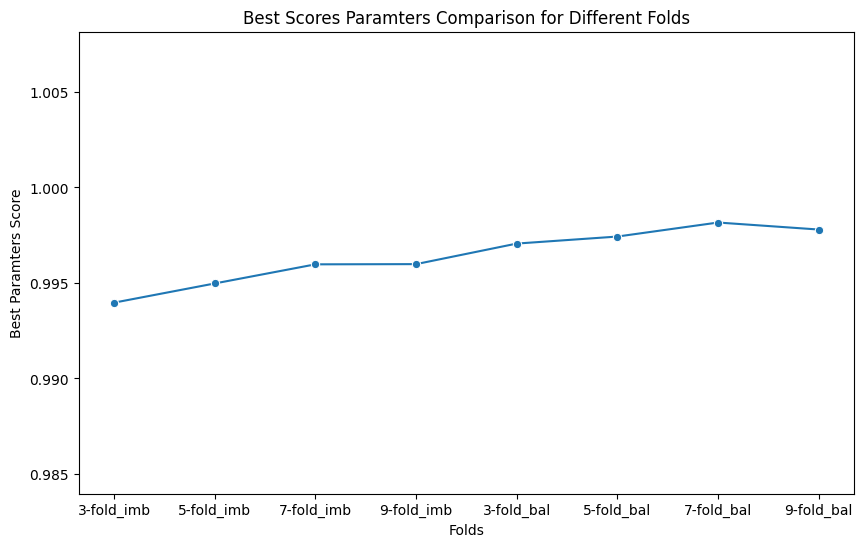

In [535]:
# Plot barplot untuk perbandingan best score
plt.figure(figsize=(10, 6))
# sns.barplot(x='Folds', y='Best Paramters Score', data=results_params_df)
sns.lineplot(x='Folds', y='Best Paramters Score', data=results_params_df, marker='o')
plt.title('Best Scores Paramters Comparison for Different Folds')
plt.xlabel('Folds')
plt.ylabel('Best Paramters Score')
plt.ylim(results_params_df['Best Paramters Score'].min() - 0.01, results_params_df['Best Paramters Score'].max() + 0.01) # Adjust y-axis limits for better visibility
plt.show()

#### Melakukan prediksi Model menggunakan 7-fold data balance

Hasil akurasi parameter terbaik diperoleh pada 7-fold. Oleh karena itu, akan digunakan untuk melakukan prediksi

In [540]:
print('Train Score Model    :', gridSearch_k7_bal.score(X_train_bal, y_train_bal))
print('Test Score Model     :', gridSearch_k7_bal.score(X_test_bal, y_test_bal))

Train Score Model    : 0.9985315712187959
Test Score Model     : 0.9970631424375918


In [541]:
# preduction
y_pred = gridSearch_k7_bal.predict(X_test_bal)
print(classification_report(y_test_bal, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       211
           0       1.00      0.99      1.00       232
           1       0.99      1.00      1.00       238

    accuracy                           1.00       681
   macro avg       1.00      1.00      1.00       681
weighted avg       1.00      1.00      1.00       681



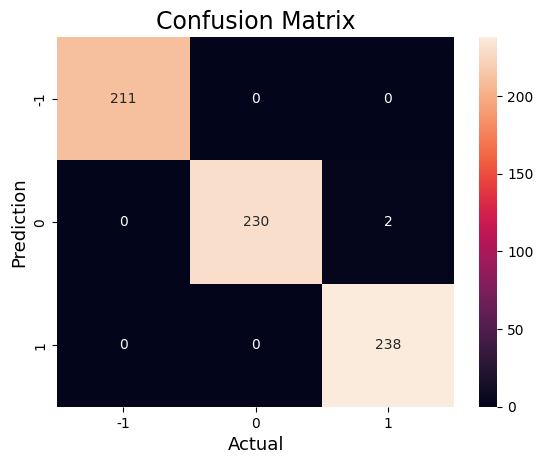

In [543]:
# compute the confusion matrix
cm = confusion_matrix(y_test_bal, y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

##### Save hasil nilai parameter SVM pada tiap cv

##### Save hasil parameter data imbalance

In [ ]:
# Membuat DataFrame dari hasil grid search untuk 3-fold, 5-fold, 7-fold dan 9-fold pada data imbalance
# Data Imbalance
saveData_k3 = pd.DataFrame(gridSearch_k3_imb.cv_results_).sort_values('rank_test_Accuracy')
saveData_k5 = pd.DataFrame(gridSearch_k5_imb.cv_results_).sort_values('rank_test_Accuracy')
saveData_k7 = pd.DataFrame(gridSearch_k7_imb.cv_results_).sort_values('rank_test_Accuracy')
saveData_k9 = pd.DataFrame(gridSearch_k9_imb.cv_results_).sort_values('rank_test_Accuracy')

# Save dalam format excel
with pd.ExcelWriter('all cv results params Imb.xlsx') as writer:
    saveData_k3.to_excel(writer, sheet_name='k3', index=False)
    saveData_k5.to_excel(writer, sheet_name='k5', index=False)
    saveData_k7.to_excel(writer, sheet_name='k7', index=False)
    saveData_k9.to_excel(writer, sheet_name='k9', index=False)

##### Save hasil parameter data imbalance

In [ ]:
# Data Balance
saveData_k3 = pd.DataFrame(gridSearch_k3_bal.cv_results_).sort_values('rank_test_Accuracy')
saveData_k5 = pd.DataFrame(gridSearch_k5_bal.cv_results_).sort_values('rank_test_Accuracy')
saveData_k7 = pd.DataFrame(gridSearch_k7_bal.cv_results_).sort_values('rank_test_Accuracy')
saveData_k9 = pd.DataFrame(gridSearch_k9_bal.cv_results_).sort_values('rank_test_Accuracy')

# Save dalam format excel
with pd.ExcelWriter('all cv results params Bal.xlsx') as writer:
    saveData_k3.to_excel(writer, sheet_name='k3', index=False)
    saveData_k5.to_excel(writer, sheet_name='k5', index=False)
    saveData_k7.to_excel(writer, sheet_name='k7', index=False)
    saveData_k9.to_excel(writer, sheet_name='k9', index=False)

##### Tanpa menggunakan GridSearch

In [544]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [545]:
# Data yang akan digunakan
X = df_smote[['Open', 'Low', 'High', 'Close', 'Adj Close', 'Volume', 'RSI']]
y = df_smote['Target']

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [557]:
# Definisikan model SVM dengan parameter yang telah Anda tentukan
svm_model = SVC(kernel='rbf', C=1000, gamma=0.1)  # Disesuaikan dengan parameter yang Anda inginkan

In [558]:
cv_score = cross_val_score(svm_model, X_train, y_train, cv=7)
print("Accuracy on test data:", cv_score)
print("Accuracy on test data:", cv_score.mean())

Accuracy on test data: [0.99487179 1.         1.         0.99485861 1.         0.99742931
 1.        ]
Accuracy on test data: 0.9981656732299405


In [559]:
# Lakukan cross-validation dengan nilai k-fold = 3
cv_predictions = cross_val_predict(svm_model, X_train, y_train, cv=3)

In [560]:
# preduction pada data uji
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [561]:
accuracy = accuracy_score(y_test, y_pred)

In [555]:
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.9970631424375918


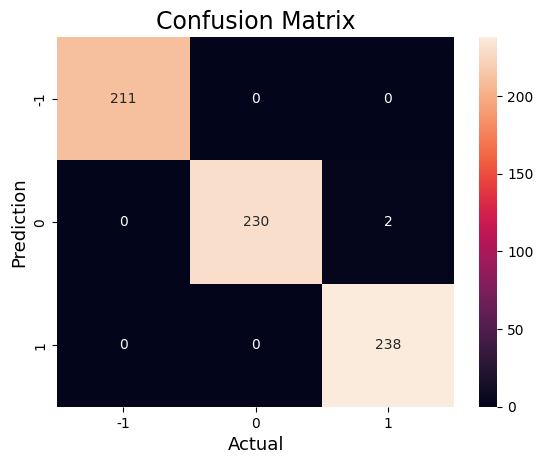

In [562]:
# compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
 
#Plot the confusion matrix.
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['-1', '0', '1'],
            yticklabels=['-1', '0', '1'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
